# Librerías

In [2]:
from datetime import date
import time
import sys
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from astropy.table import Table
from astroquery.sdss import SDSS
from matplotlib import pyplot as plt

import astropy.units as u
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from astropy.coordinates import SkyCoord

# Extract Data

In [3]:
query_sdss = """SELECT TOP 100000
        s.specobjid, s.ra, s.dec, g.h_alpha_flux, g.h_beta_flux, 
        g.sii_6717_flux, g.sii_6731_flux, g.nii_6548_flux, g.nii_6584_flux,
        g.oi_6300_flux, g.oii_3726_flux, g.oii_3729_flux, g.oiii_5007_flux,
        g.h_alpha_eqw, p.u,p.g,p.r,p.i,p.z,s.z as redshift,ID.bptclass
                
        FROM SpecObjAll AS s
        JOIN galSpecExtra AS ID ON ID.specObjID = s.specObjID
        JOIN galSpecLine AS g ON g.specObjID = s.specObjID
        JOIN PhotoObj AS p ON p.objID = s.bestObjID
                
        WHERE 
        s.z <=1
        AND s.class IN ('QSO','GALAXY')
        AND g.h_alpha_flux >0 AND g.h_beta_flux >0
        AND g.sii_6717_flux >0 AND g.sii_6731_flux >0 
        AND g.nii_6548_flux >0 AND g.nii_6584_flux >0
        AND g.oii_3726_flux >0 AND g.oii_3729_flux >0
        AND g.oi_6300_flux >0 AND g.oiii_5007_flux >0         
        AND p.u >0 AND p.g >0 AND p.r >0 AND p.i >0 AND p.z >0   
        --ORDER BY redshift DESC
        """

data_sdss = SDSS.query_sql(query_sdss)
t=Table(data_sdss)
sdss_df=t.to_pandas()

# Prepare Data

In [4]:
sdss_df['ra'] = sdss_df['ra'].astype(str) 
sdss_df['dec'] = sdss_df['dec'].astype(str) 
sdss_df['Full Name'] = sdss_df[['ra','dec']].agg(' - '.join, axis=1) 
sdss_df = sdss_df.drop_duplicates(subset = ['Full Name']).reset_index(drop=True)
sdss_df

,specobjid,ra,dec,h_alpha_flux,h_beta_flux,sii_6717_flux,sii_6731_flux,nii_6548_flux,nii_6584_flux,oi_6300_flux,...,oiii_5007_flux,h_alpha_eqw,u,g,r,i,z,redshift,bptclass,Full Name
0,468486543057643520,55.025607,1.0468628,655.87850,176.751500,125.232900,80.226520,52.629380,158.74230,21.431050,...,154.137800,-66.225410,19.64422,18.45694,18.03195,17.65956,17.58342,0.097647,1,55.025607 - 1.0468628
1,468498637685549056,55.593648,1.0000517,223.17350,65.259310,48.582550,34.271940,17.350540,52.33324,6.054294,...,42.659520,-41.931740,19.20572,18.09703,17.64738,17.32270,17.13651,0.072320,1,55.593648 - 1.0000517
2,1195829989820360704,56.021232,0.898451,180.32390,56.169690,34.285130,25.218680,13.437070,40.52929,7.051508,...,55.101390,-36.890490,20.50351,19.34904,18.79929,18.46986,18.28808,0.133791,1,56.021232 - 0.898451
3,468529698889033728,56.193033,0.98180746,97.47672,22.133890,14.541530,16.941370,15.854970,47.82225,1.078711,...,5.707779,-6.963751,20.87063,19.12356,17.88638,17.31699,17.03969,0.216304,2,56.193033 - 0.98180746
4,1195854179076171776,56.167007,0.84159549,101.01250,14.396120,12.678210,4.902872,9.604029,28.96797,7.816971,...,5.247120,-43.318690,22.20453,21.47315,20.31594,19.97563,19.34771,0.356389,2,56.167007 - 0.84159549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93373,843467842606098432,358.94409,15.853116,440.35510,121.696900,82.083660,58.192300,45.926400,138.52460,10.685250,...,57.355390,-52.154970,19.49282,18.86239,24.80398,24.43497,19.92200,0.107078,1,358.94409 - 15.853116
93374,824234360495433728,324.82284,10.362944,29.06874,10.856860,16.429440,7.651928,4.152757,12.52567,4.992753,...,21.737960,-0.935891,18.69371,16.88964,16.04723,15.65011,15.34778,0.036863,2,324.82284 - 10.362944
93375,838866386980726784,349.93435,13.365865,33.88130,8.334444,9.589079,6.068667,8.577262,25.87100,2.356097,...,5.529158,-3.757100,20.58996,18.71064,17.69946,17.21834,16.85664,0.138374,5,349.93435 - 13.365865
93376,846691061362354176,4.1152955,13.823563,17.86226,8.819551,2.150577,2.333953,6.865606,20.70825,4.117427,...,16.380890,-0.454261,19.10770,17.11502,16.17595,15.74369,15.40534,0.070419,-1,4.1152955 - 13.823563


### Ratio Lines 

In [5]:
ejex1=np.log10((sdss_df['nii_6548_flux']+sdss_df['nii_6584_flux'])/sdss_df['h_alpha_flux'])
ejex2=np.log10((sdss_df['sii_6717_flux']+sdss_df['sii_6731_flux'])/sdss_df['h_alpha_flux'])
ejex3=np.log10(sdss_df['oi_6300_flux']/sdss_df['h_alpha_flux'])
ejex4=np.log10((sdss_df['oii_3726_flux']+sdss_df['oii_3729_flux'])/sdss_df['h_alpha_flux'])
ejex5=np.log10((sdss_df['oii_3726_flux']+sdss_df['oii_3729_flux'])/sdss_df['h_beta_flux'])

ejey=np.log10((sdss_df['oiii_5007_flux'])/(sdss_df['h_beta_flux']))
ejey2=np.log10(np.abs(sdss_df['h_alpha_eqw']))

### Features Table

In [6]:
sdss_df['OIII/Hβ']=ejey
sdss_df['NII/Hα']=ejex1
sdss_df['SII/Hα']=ejex2
sdss_df['OI/Hα']=ejex3
sdss_df['OII/Hα']=ejex4
sdss_df['OII/Hβ']=ejex5
sdss_df['W_Hα']=ejey2

#U-B
sdss_df['U']=(sdss_df['u']-0.0682)-(0.0140*(sdss_df['u']-sdss_df['g']-1.2638))
sdss_df['B']=(sdss_df['u']-1.0286)-(0.7981*(sdss_df['u']-sdss_df['g']-1.2638))
sdss_df['U-B']=(sdss_df['U']-sdss_df['B'])

#UGRIZ
sdss_df['u-r']=sdss_df['u']-sdss_df['r']
sdss_df['g-z']=sdss_df['g']-sdss_df['z']

data=sdss_df[['OIII/Hβ','NII/Hα','SII/Hα','OI/Hα','OII/Hα','OII/Hβ','U-B','u-r','g-z','W_Hα']].dropna()
data

,OIII/Hβ,NII/Hα,SII/Hα,OI/Hα,OII/Hα,OII/Hβ,U-B,u-r,g-z,W_Hα
0,-0.059454,-0.491777,-0.504097,-1.485780,-0.174225,0.395235,0.900401,1.61227,0.87352,1.821025
1,-0.184627,-0.505511,-0.430327,-1.566579,-0.108646,0.425354,0.838778,1.55834,0.96052,1.622543
2,-0.008339,-0.523930,-0.481509,-1.407771,-0.004583,0.501968,0.874674,1.70422,1.06096,1.566914
3,-0.588591,-0.184917,-0.490826,-1.955996,-0.355134,0.288710,1.339332,2.98425,2.08387,0.842843
4,-0.438324,-0.418103,-0.759330,-1.111337,-0.693322,0.152808,0.542929,1.88859,2.12544,1.636675
...,...,...,...,...,...,...,...,...,...,...
93373,-0.326705,-0.377922,-0.496820,-1.615018,-0.233646,0.324878,0.463775,-5.31116,-1.05961,1.717296
93374,0.301515,-0.241271,-0.081745,-0.765086,-0.001661,0.426061,1.384026,2.64648,1.54186,-0.028775
93375,-0.178218,0.007207,-0.335231,-1.157767,-0.181638,0.427446,1.443029,2.89050,1.85400,0.574853
93376,0.268891,0.188561,-0.600219,-0.637310,-0.151807,0.154683,1.531915,2.93175,1.70968,-0.342694


In [7]:
dataset_test = data.values
dataset_test

array([[-0.05945395, -0.4917766 , -0.50409734, ...,  1.61227   ,
         0.87352   ,  1.82102466],
       [-0.18462651, -0.50551092, -0.43032658, ...,  1.55834   ,
         0.96052   ,  1.62254288],
       [-0.00833947, -0.52393017, -0.48150852, ...,  1.70422   ,
         1.06096   ,  1.56691442],
       ...,
       [-0.17821763,  0.00720725, -0.33523082, ...,  2.8905    ,
         1.854     ,  0.57485275],
       [ 0.26889102,  0.1885611 , -0.60021947, ...,  2.93175   ,
         1.70968   , -0.34269407],
       [ 0.40507889,  0.18971074, -0.44501781, ...,  3.25412   ,
         2.0868    ,  0.14431137]])

# Data Training

In [8]:
train=pd.read_csv('Base_Training.csv')
train

,OIII/Hβ(T),NII/Hα(T),SII/Hα(T),OI/Hα(T),OII/Hα(T),OII/Hβ(T),U-B(T),u-r(T),g-z(T),W_Hα(T),Class
0,-0.344456,-0.110662,-0.465258,-1.371657,-0.465562,0.211951,0.991168,2.03257,1.46111,1.531800,0
1,0.230158,0.206171,-0.114820,-0.790380,-0.147776,0.494771,1.421427,2.64454,1.45824,0.622383,1
2,-0.321700,-0.029606,-0.391567,-1.401415,-0.447159,0.246690,1.331828,2.75139,1.95833,0.833462,0
3,-0.145686,-0.229361,-0.389954,-1.749050,-0.221426,0.394638,0.968170,1.87140,1.17563,1.273027,0
4,0.811414,0.498772,0.173848,-0.771357,-0.010496,0.741806,1.188659,2.65146,1.90029,0.506689,1
...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.266787,-0.448757,-0.457349,-1.483981,-0.182135,0.424815,0.810441,1.46833,0.86616,1.648110,3
19996,0.354763,-0.990792,-0.567610,-1.307850,-0.031434,0.414333,0.891384,1.24855,0.30511,1.460780,3
19997,-0.409017,-0.333843,-0.491029,-1.553155,-0.374088,0.177846,0.963278,1.86258,1.07050,1.306306,3
19998,-0.285944,-0.362537,-0.453382,-1.539884,-0.274939,0.293220,0.800514,1.58810,0.98450,1.517298,3


In [9]:
from tensorflow.keras.utils import to_categorical
dataset_train = train.values
x_train = dataset_train[:,0:10].astype(float)
y = dataset_train[:,10]
y_train=to_categorical(y)

# Neural Networks

In [10]:
from keras.models import Sequential
from keras.layers import LeakyReLU

model = Sequential()
model.add(Dense(50, input_dim=10, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_normal'))
model.add(Dense(20, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(10, activation=LeakyReLU(alpha=0.1)))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
hist=model.fit(x_train,y_train, batch_size=50, epochs=100, validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 2s 3ms/step - loss: 0.6056 - accuracy: 0.7781 - val_loss: 0.2541 - val_accuracy: 0.9105
Epoch 2/100
360/360 [==============================] - 1s 3ms/step - loss: 0.2763 - accuracy: 0.8940 - val_loss: 0.1296 - val_accuracy: 0.9735
Epoch 3/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1928 - accuracy: 0.9278 - val_loss: 0.2035 - val_accuracy: 0.9220
Epoch 4/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1568 - accuracy: 0.9422 - val_loss: 0.2190 - val_accuracy: 0.9065
Epoch 5/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1316 - accuracy: 0.9538 - val_loss: 0.0479 - val_accuracy: 0.9915
Epoch 6/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1189 - accuracy: 0.9556 - val_loss: 0.1064 - val_accuracy: 0.9680
Epoch 7/100
360/360 [==============================] - 1s 3ms/step - loss: 0.1044 - accuracy: 0.9623 - val_loss: 0.0553 - val_accuracy: 0.9870

Epoch 58/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9862 - val_loss: 0.0229 - val_accuracy: 0.9910
Epoch 59/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0310 - accuracy: 0.9867 - val_loss: 0.0201 - val_accuracy: 0.9955
Epoch 60/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0320 - accuracy: 0.9872 - val_loss: 0.1245 - val_accuracy: 0.9415
Epoch 61/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9858 - val_loss: 0.0298 - val_accuracy: 0.9890
Epoch 62/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0360 - accuracy: 0.9848 - val_loss: 0.0097 - val_accuracy: 0.9980
Epoch 63/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0318 - accuracy: 0.9868 - val_loss: 0.0093 - val_accuracy: 0.9970
Epoch 64/100
360/360 [==============================] - 1s 3ms/step - loss: 0.0356 - accuracy: 0.9852 - val_loss: 0.0726 - val_accuracy:

In [12]:
x_test = model.predict(dataset_test)
y_test_class = np.argmax(x_test, axis=1)
x_test

2919/2919 [==============================] - 6s 2ms/step


array([[2.39686115e-09, 3.43286122e-16, 9.65607737e-19, 1.00000000e+00],
       [1.09486035e-13, 5.01857354e-19, 1.67044152e-23, 1.00000000e+00],
       [6.29409413e-10, 8.47882760e-17, 1.82255806e-18, 1.00000000e+00],
       ...,
       [9.17501211e-01, 8.24987516e-02, 6.68064176e-26, 4.07957812e-32],
       [2.18825010e-11, 1.00000000e+00, 2.28571345e-17, 0.00000000e+00],
       [3.52911576e-15, 1.00000000e+00, 4.00888090e-14, 0.00000000e+00]],
      dtype=float32)

In [13]:
y_test_class

array([3, 3, 3, ..., 0, 1, 1], dtype=int64)

In [14]:
df_predicciones = pd.DataFrame({'prediccion' : y_test_class})
df_predicciones

,prediccion
0,3
1,3
2,3
3,0
4,3
...,...
93373,3
93374,0
93375,0
93376,1


In [15]:
scores = model.evaluate(x_train, y_train, verbose=0)
print('Precisión del modelo: {}\n Error del modelo: {}'.format(scores[1], 1 - scores[1]))   

Precisión del modelo: 0.9937999844551086
 Error del modelo: 0.006200015544891357


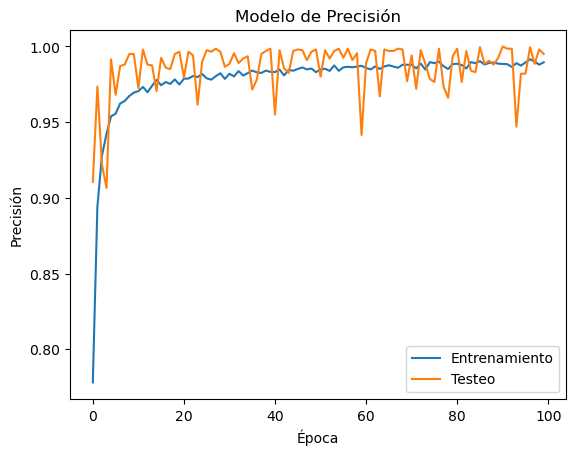

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Modelo de Precisión')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Testeo'], loc='lower right')
plt.show()

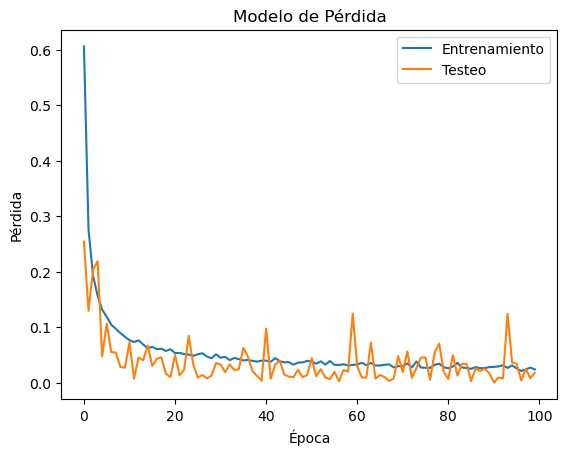

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Modelo de Pérdida')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper right')
plt.show()

In [18]:
column_names = ['OIII/Hβ','NII/Hα','SII/Hα','OI/Hα','OII/Hα','OII/Hβ','U-B','u-r','g-z','W_Hα']
df=pd.DataFrame(dataset_test,columns=column_names)
df['Predicted Class'] = pd.Series(y_test_class)
df

,OIII/Hβ,NII/Hα,SII/Hα,OI/Hα,OII/Hα,OII/Hβ,U-B,u-r,g-z,W_Hα,Predicted Class
0,-0.059454,-0.491777,-0.504097,-1.485780,-0.174225,0.395235,0.900401,1.61227,0.87352,1.821025,3
1,-0.184627,-0.505511,-0.430327,-1.566579,-0.108646,0.425354,0.838778,1.55834,0.96052,1.622543,3
2,-0.008339,-0.523930,-0.481509,-1.407771,-0.004583,0.501968,0.874674,1.70422,1.06096,1.566914,3
3,-0.588591,-0.184917,-0.490826,-1.955996,-0.355134,0.288710,1.339332,2.98425,2.08387,0.842843,0
4,-0.438324,-0.418103,-0.759330,-1.111337,-0.693322,0.152808,0.542929,1.88859,2.12544,1.636675,3
...,...,...,...,...,...,...,...,...,...,...,...
93373,-0.326705,-0.377922,-0.496820,-1.615018,-0.233646,0.324878,0.463775,-5.31116,-1.05961,1.717296,3
93374,0.301515,-0.241271,-0.081745,-0.765086,-0.001661,0.426061,1.384026,2.64648,1.54186,-0.028775,0
93375,-0.178218,0.007207,-0.335231,-1.157767,-0.181638,0.427446,1.443029,2.89050,1.85400,0.574853,0
93376,0.268891,0.188561,-0.600219,-0.637310,-0.151807,0.154683,1.531915,2.93175,1.70968,-0.342694,1


In [19]:
comp=df['Predicted Class']==0
lin=df['Predicted Class']==1
sf=df['Predicted Class']==2
sb=df['Predicted Class']==3

## BPT Diagram 

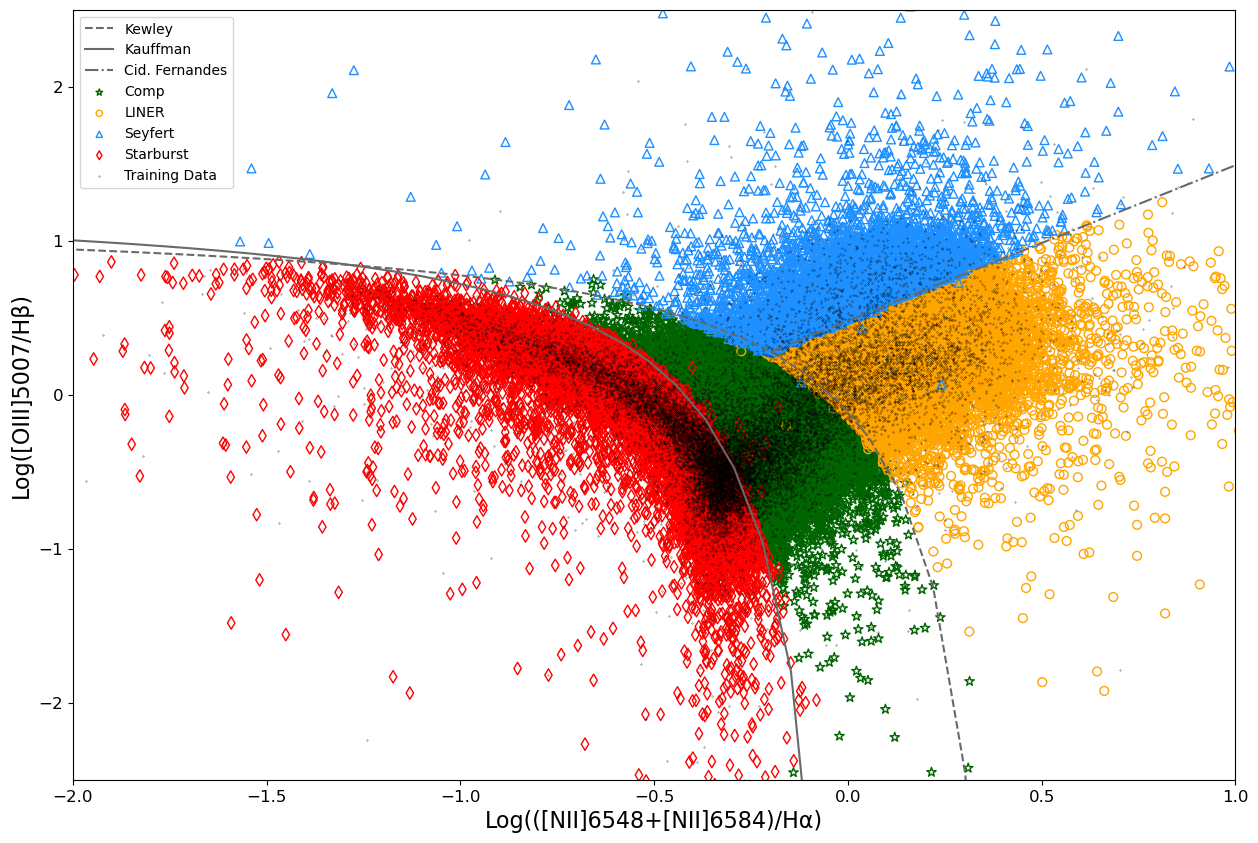

In [20]:
# Kewley
x1 = np.linspace(-3.6,0.469)
y1 = 1.19 + (0.61/(x1-0.47))

#Kauffman
x2 = np.linspace(-3.6,0.0) 
y2 = 1.3 + (0.61/(x2-0.05))

#Cid-Fernandes
x3 = np.linspace(-0.2,4.0) 
y3 = 0.48 +(1.01*x3)

fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(1,1,1)
ax0.plot(x1, y1, '--' , color='dimgray',lw=1.5, label='Kewley') 
ax0.plot(x2, y2, '-' , color='dimgray', lw=1.5, label='Kauffman') 
ax0.plot(x3, y3, '-.' , color='dimgray', lw=1.5, label='Cid. Fernandes') 

ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],comp*50, marker='*',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],lin*40, marker='o',facecolors="none",edgecolors="orange",label='LINER') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],sf*40, marker='^',facecolors="none",edgecolors="dodgerblue",label='Seyfert') 
ax0.scatter(df['NII/Hα'], df['OIII/Hβ'],sb*40, marker='d',facecolors="none",edgecolors="red",label='Starburst') 
ax0.scatter(train['NII/Hα(T)'], train['OIII/Hβ(T)'], c="black", s=0.05,label='Training Data') 

ax0.set_ylim(-2.5,2.5) 
ax0.set_xlim(-2,1) 
ax0.set_xlabel(r'Log(([NII]6548+[NII]6584)/Hα)',fontsize=16) 
ax0.set_ylabel(r'Log([OIII]5007/Hβ)',fontsize=16)
ax0.tick_params(axis='both', which='major', labelsize=12) 
plt.legend()
plt.show()

## WHAN Diagram

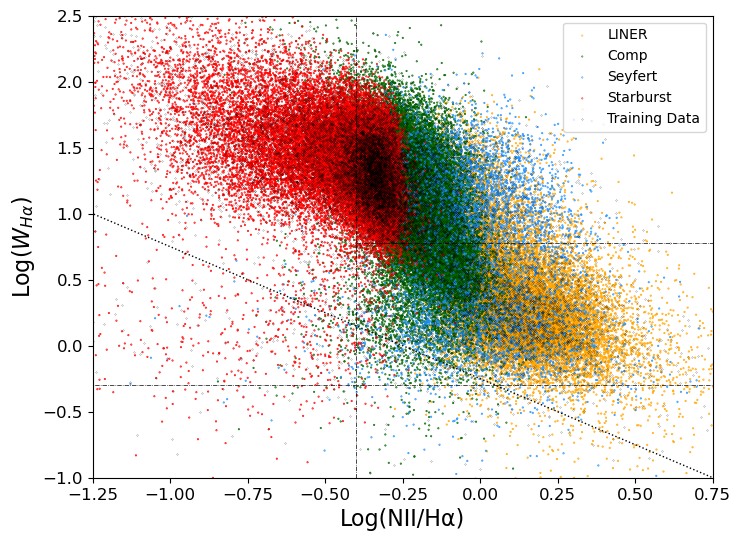

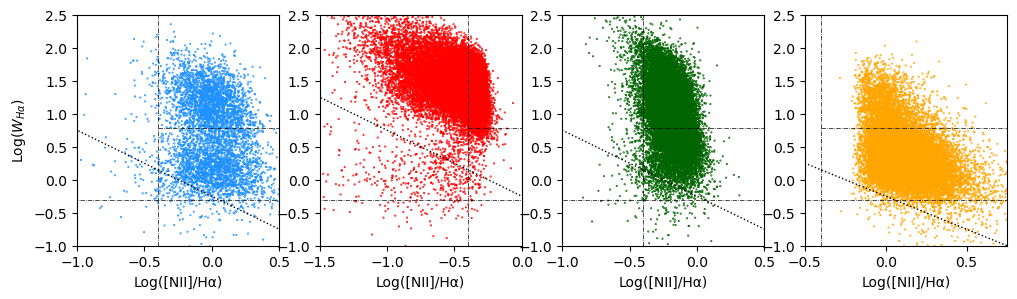

In [23]:
eqwx=df['NII/Hα']
eqwy=df['W_Hα']

fig, ax = plt.subplots(figsize=(8,6)) 

ax.scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(train['NII/Hα(T)'], train['W_Hα(T)'], c="black", s=0.02,label='Training Data') 
ax.axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax.hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax.hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
x = np.linspace(-3,3)
y=(-1*x)-0.25
ax.plot(x,y,':', color='black',lw=1) 
ax.legend()
ax.set_xlim(-1.25,0.75)
ax.set_ylim(-1,2.5)
ax.set_xlabel(r'Log(NII/Hα)',fontsize=16) 
ax.set_ylabel(r'Log($W_{Hα}$)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')
ax[0].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[0].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[0].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[0].plot(x,y,':', color='black',lw=1) 
ax[1].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[1].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[1].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[1].plot(x,y,':', color='black',lw=1) 
ax[2].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[2].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[2].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[2].plot(x,y,':', color='black',lw=1) 
ax[3].axvline(x=-0.4, color='black', linestyle='-.', lw=0.5)
ax[3].hlines(y=0.778, xmin=-0.4, xmax=3, color='black', linestyle='-.', lw=0.5)
ax[3].hlines(y=-0.3, xmin=-4, xmax=7, color='black', linestyle='-.', lw=0.5)
ax[3].plot(x,y,':', color='black',lw=1) 
ax[0].set_xlim(-1,0.5)
ax[1].set_xlim(-1.5,0)
ax[2].set_xlim(-1,0.5)
ax[3].set_xlim(-0.5,0.75)
ax[0].set_ylim(-1,2.5)
ax[1].set_ylim(-1,2.5)
ax[2].set_ylim(-1,2.5)
ax[3].set_ylim(-1,2.5)
ax[0].set_xlabel(r'Log([NII]/Hα)')
ax[1].set_xlabel(r'Log([NII]/Hα)')
ax[2].set_xlabel(r'Log([NII]/Hα)')
ax[3].set_xlabel(r'Log([NII]/Hα)')
ax[0].set_ylabel(r'Log($W_{Hα}$)')
plt.show()

## Blue Diagram

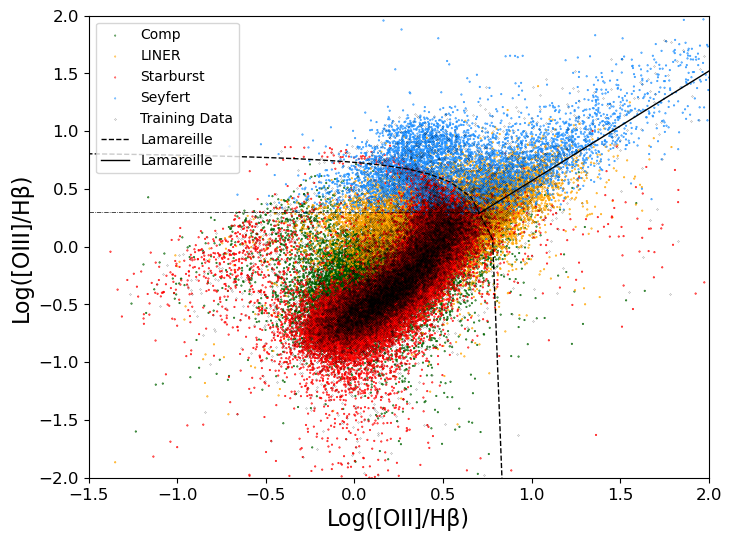

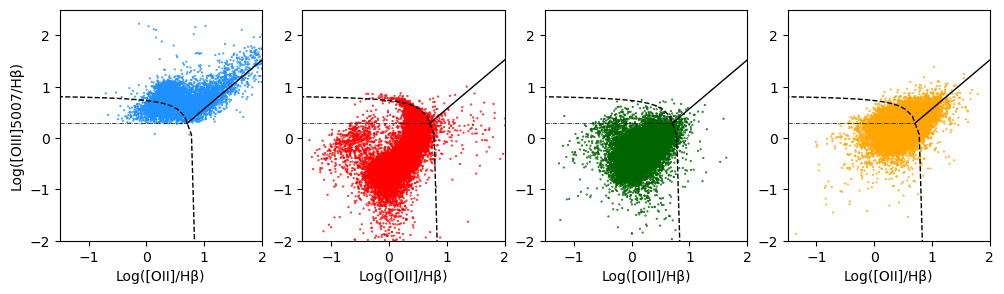

In [22]:
eqwx=df['OII/Hβ']
eqwy=df['OIII/Hβ']

x11 = np.linspace(-5,0.9)
y11 = 0.85 + (0.11/(x11-0.92))

x22 = np.linspace(0.7,4)
y22 = 0.95 * (x22-0.4)

x6 = np.linspace(-5,0.7)
y6 = 0.3+ (x6*0)

x7 = np.linspace(0.05, 1.07)
y7 = (-(x7 - 1.0)**2) - (0.1*x7) + 0.25
x8 = np.linspace(0.05 ,1.07)
y8 = ((x8 - 0.2)**2) - 0.6

fig, ax = plt.subplots(figsize=(8,6)) 
ax.scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(train['OII/Hβ(T)'], train['OIII/Hβ(T)'], c="black", s=0.02,label='Training Data') 
ax.plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax.plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax.hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)
ax.legend()
ax.set_xlim(-1.5,2)
ax.set_ylim(-2,2)
ax.set_xlabel(r'Log([OII]/Hβ)',fontsize=16) 
ax.set_ylabel(r'Log([OIII]/Hβ)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(eqwx,eqwy, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(eqwx,eqwy, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(eqwx,eqwy, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(eqwx,eqwy, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')

ax[0].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[0].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[0].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[1].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[1].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[1].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[2].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[2].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[2].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[3].plot(x11, y11, '--' , color='black',lw=1, label='Lamareille') 
ax[3].plot(x22, y22, '-' , color='black', lw=1, label='Lamareille') 
ax[3].hlines(y=0.3, xmin=-1.5, xmax=0.7, color='black', linestyle='-.', lw=0.5)

ax[0].set_xlim(-1.5,2)
ax[1].set_xlim(-1.5,2)
ax[2].set_xlim(-1.5,2)
ax[3].set_xlim(-1.5,2)
ax[0].set_ylim(-2,2.5)
ax[1].set_ylim(-2,2.5)
ax[2].set_ylim(-2,2.5)
ax[3].set_ylim(-2,2.5)
ax[0].set_xlabel(r'Log([OII]/Hβ)')
ax[1].set_xlabel(r'Log([OII]/Hβ)')
ax[2].set_xlabel(r'Log([OII]/Hβ)')
ax[3].set_xlabel(r'Log([OII]/Hβ)')
ax[0].set_ylabel(r'Log([OIII]5007/Hβ)')
plt.show()

# Photometry

## Color-Color Diagram

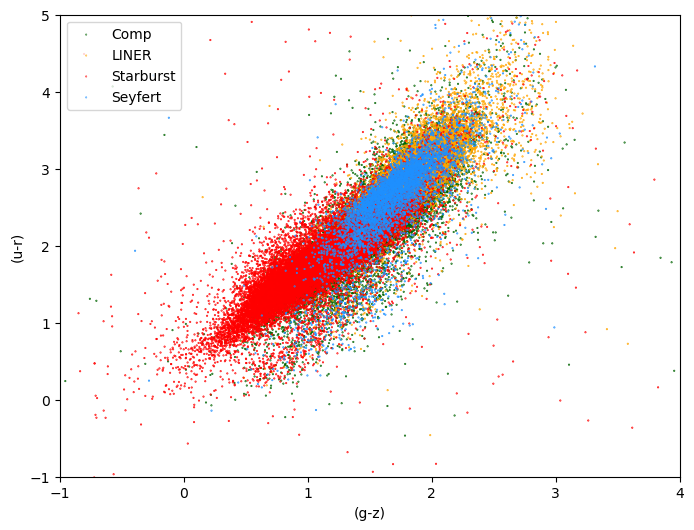

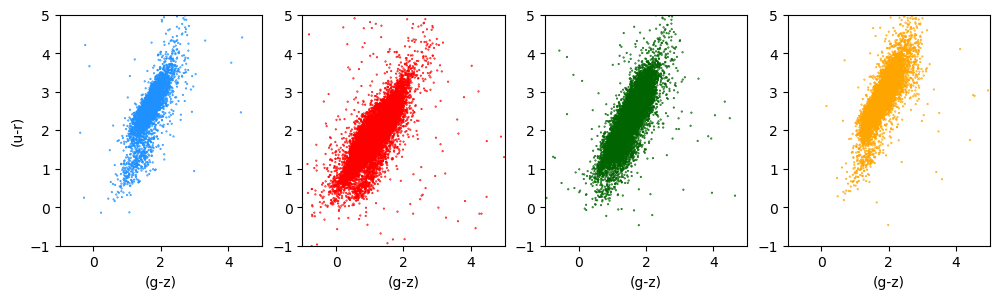

In [24]:
ejexgz=df['g-z']
ejeyur=df['u-r']

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(ejexgz,ejeyur, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(ejexgz,ejeyur, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(ejexgz,ejeyur, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(ejexgz,ejeyur, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.legend()
ax.set_xlim(-1,4)
ax.set_ylim(-1,5)
ax.set_xlabel(r'(g-z)') 
ax.set_ylabel(r'(u-r)')
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(ejexgz,ejeyur, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(ejexgz,ejeyur, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(ejexgz,ejeyur, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(ejexgz,ejeyur, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')

ax[0].set_xlim(-1,5)
ax[1].set_xlim(-1,5)
ax[2].set_xlim(-1,5)
ax[3].set_xlim(-1,5)
ax[0].set_ylim(-1,5)
ax[1].set_ylim(-1,5)
ax[2].set_ylim(-1,5)
ax[3].set_ylim(-1,5)
ax[0].set_xlabel(r'(g-z)') 
ax[1].set_xlabel(r'(g-z)') 
ax[2].set_xlabel(r'(g-z)') 
ax[3].set_xlabel(r'(g-z)') 
ax[0].set_ylabel(r'(u-r)')
plt.show()

## U-B Diagram

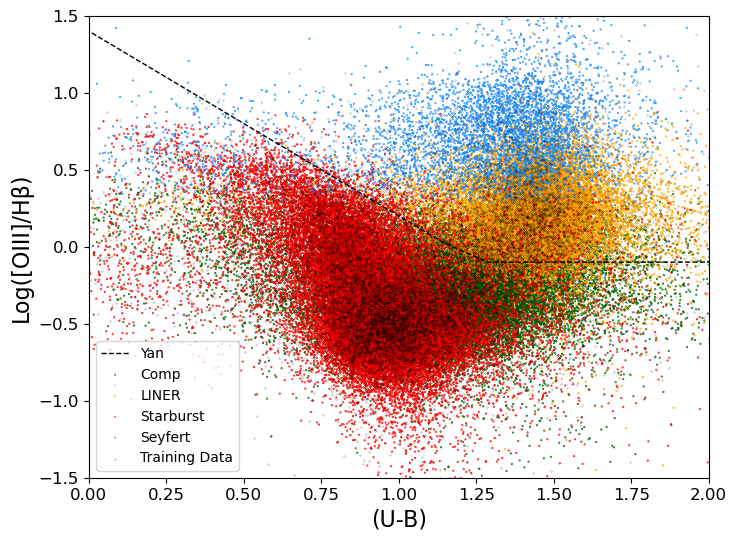

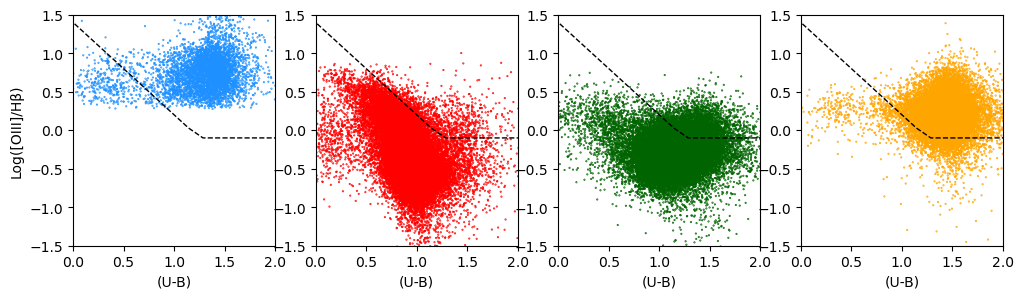

In [25]:
x1 = np.linspace(-2,5)
a=1.4-(1.2*x1)
a[a <= -0.1] = -0.1

ejexub=df['U-B']
ejeyub=df['OIII/Hβ']

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x1,a,'--', color='black',lw=1, label='Yan') 
ax.scatter(ejexub,ejeyub, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax.scatter(ejexub,ejeyub, lin*1, marker='.',facecolors="none",edgecolors="orange",label='LINER')
ax.scatter(ejexub,ejeyub, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax.scatter(ejexub,ejeyub, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax.scatter(train['U-B(T)'], train['OIII/Hβ(T)'], c="black", s=0.02,label='Training Data')
ax.legend()
ax.set_xlim(0,2)
ax.set_ylim(-1.5,1.5)
ax.set_xlabel(r'(U-B)',fontsize=16) 
ax.set_ylabel(r'Log([OIII]/Hβ)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(12,3))
ax[0].scatter(ejexub,ejeyub, sf*1, marker='.',facecolors="none",edgecolors="dodgerblue",label='Seyfert')
ax[1].scatter(ejexub,ejeyub, sb*1, marker='.',facecolors="none",edgecolors="red",label='Starburst')
ax[2].scatter(ejexub,ejeyub, comp*1, marker='.',facecolors="none",edgecolors="darkgreen",label='Comp') 
ax[3].scatter(ejexub,ejeyub, lin*1, marker='.',facecolors="none",edgecolors="orange",label='Liner')
ax[0].plot(x1,a,'--', color='black',lw=1) 
ax[1].plot(x1,a,'--', color='black',lw=1) 
ax[2].plot(x1,a,'--', color='black',lw=1) 
ax[3].plot(x1,a,'--', color='black',lw=1)
ax[0].set_xlim(0,2)
ax[1].set_xlim(0,2)
ax[2].set_xlim(0,2)
ax[3].set_xlim(0,2)
ax[0].set_ylim(-1.5,1.5)
ax[1].set_ylim(-1.5,1.5)
ax[2].set_ylim(-1.5,1.5)
ax[3].set_ylim(-1.5,1.5)
ax[0].set_xlabel(r'(U-B)') 
ax[1].set_xlabel(r'(U-B)') 
ax[2].set_xlabel(r'(U-B)') 
ax[3].set_xlabel(r'(U-B)') 
ax[0].set_ylabel(r'Log([OIII]/Hβ)')
plt.show()

# 3D Projection

In [26]:
df['Predicted Class']=df['Predicted Class'].replace({0:'Comp', 1:'Liner', 2:'Seyfert', 3:'Starburst'})
comp=df['Predicted Class']=='Comp'
lin=df['Predicted Class']=='LINER'
sf=df['Predicted Class']=='Seyfert'
sb=df['Predicted Class']=='Starburst'

## BPT vs. WHAN 

In [ ]:
%matplotlib qt
ejex1=df['W_Hα']
ejey1=df['NII/Hα']
ejez1=df['OIII/Hβ']
labels=df['Predicted Class']
df1 = pd.DataFrame(dict(x=ejex1, y=ejey1, z=ejez1, label=labels))

groups = df1.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)
    
ax.scatter(train['W_Hα(T)'],train['NII/Hα(T)'], train['OIII/Hβ(T)'], c="black",s=0.02,label='Training Data') 
ax.set_xlim(-1,3)
ax.set_ylim(-2,1)
ax.set_zlim(-1.5,1.5)
ax.set_xlabel(r'Log($W_{Hα}$)') 
ax.set_ylabel(r'Log(NII/Hα)')
ax.set_zlabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

# Blue vs. U-B

In [ ]:
%matplotlib qt
ejex1=df['U-B']
ejey1=df['OII/Hβ']
ejez1=df['OIII/Hβ']
labels=df['Predicted Class']
df1 = pd.DataFrame(dict(x=ejex1, y=ejey1, z=ejez1, label=labels))

groups = df1.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)
    
ax.scatter(train['U-B(T)'],train['OII/Hβ(T)'], train['OIII/Hβ(T)'], c="black",s=0.02,label='Training Data') 
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-1,2)
ax.set_zlim(-1.5,2)
ax.set_xlabel(r'(U-B)') 
ax.set_ylabel(r'Log(OII/Hβ)')
ax.set_zlabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

## Color - Color

In [ ]:
%matplotlib qt
ejex=df['g-z']
ejey=df['OIII/Hβ']
ejez=df['u-r']
labels=df['Predicted Class']
df4 = pd.DataFrame(dict(x=ejex, y=ejey, z=ejez, label=labels))

groups = df4.groupby('label')

color_palette = {'Comp': 'darkgreen', 'Liner': 'orange', 'Seyfert': 'dodgerblue', 'Starburst': 'red'}
plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
for name, group in groups:
    color = color_palette.get(name, 'gray')
    ax.plot(group.x, group.y, group.z, marker='*', linestyle='', ms=1, label=name, color=color)

ax.scatter(train['g-z(T)'], train['OIII/Hβ(T)'], train['u-r(T)'], c="black",s=0.02,label='Training Data')
ax.set_xlim(0,2.5)
ax.set_ylim(-2,2)
ax.set_zlim(0,4)
ax.set_xlabel(r'(g-z)') 
ax.set_zlabel(r'(u-r))')
ax.set_ylabel(r'Log([OIII]5007/Hβ)')
ax.legend()
plt.show()

# Statistics 

In [ ]:
fig=px.box(df, x="U-B", y="Predicted Class", points="all")
fig.update_layout(xaxis_title="(U-B)", yaxis_title="Log([NII]/Hα)")

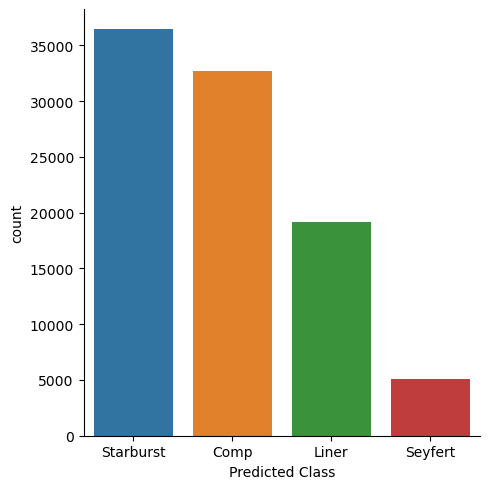

In [27]:
%matplotlib inline
w=sns.factorplot('Predicted Class',data=df,kind="count")
custom_palette = ["red","green","orange","blue"]
w=sns.set_palette(custom_palette)

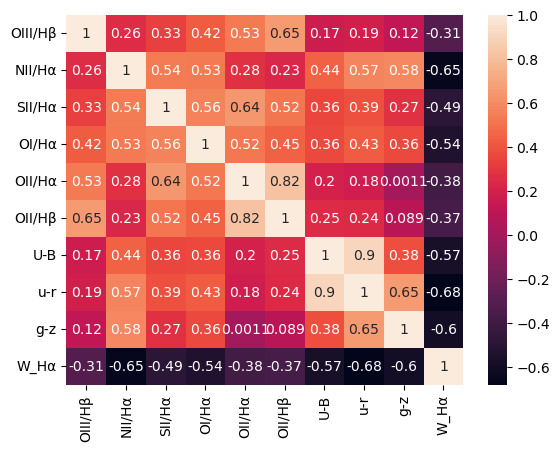

In [28]:
sns.heatmap(df.corr(), annot=True) and plt.show()